### Importação de Libs

In [129]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from skopt import gp_minimize
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [130]:
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import plotly.express as px

In [131]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import EnsembleVoteClassifier

In [132]:
from fastai.tabular.all import *
from fastai.vision.all import *
import warnings

warnings.filterwarnings('ignore')

In [79]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
y_test = pd.read_csv('test_results.csv')
y_test = y_test['Survived']
ID = test['PassengerId']
IMPUTER = KNNImputer(n_neighbors=10, weights='distance')
remove_cols = ['PassengerId', 'Name']
SEED = 42

In [80]:
def set_seed(dls, x=42): # added this line from @marii-moe's comment
    random.seed(x)
    dls.rng.seed(x) # added this line from @marii-moe's comment
    np.random.seed(x)
    torch.manual_seed(x)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(x)

### Feature Engineering

#### Making Functions and Most Important variables/constants

In [81]:
def search_title(x):
    y = list(x)
    if y.index(','):
        y = y[y.index(',') + 2:y.index(" ", y.index(',') + 2)]
        return "".join(y)

In [82]:
def to_miss(x):
    arr = ['Mlle.', 'Mme.', 'Lady.', 'Ms.', 'Dona.']
    if x in arr:
        x = 'Miss.'
    return x

In [83]:
def to_mr(x):
    arr = ['Dr.', 'Rev.', 'Col.', 'Major.', 'Capt.', 'the.', 'Jonkheer.', 'Sir.', 'Don.', 'the' , 'Master.']
    if x in arr:
        x = 'Mr.'
    return x

In [84]:
def is_married(x):
    if x == 'Mrs.':
        return 1
    return 0

In [85]:
def is_alone(x):
    if x == 0:
        return 1
    return 0

In [86]:
def below_age(x):
    if x < 18:
        return 1
    return 0

In [87]:
def vote(x):
    if x >= 0.50:
        return 1
    return 0

### Making New Features

In [88]:
cont = ['Age', 'Fare', 'family_size']
cat  = ['Sex', 'Ticket', 'SibSp', 'Parch', 'Pclass', 'Embarked', 'Title', 'is_alone', 'is_married', 'below_age', 'surname', 'Cabin']
dep_var = 'Survived'

##### To Train

In [89]:
train[['Age']] = IMPUTER.fit_transform(train[['Age']])

In [90]:
train['Title'] = train['Name'].apply(search_title) #make a column of titles
train['Title'] = train['Title'].apply(to_miss) #separate titles that can go to Miss
train['Title'] = train['Title'].apply(to_mr) #separate titles that can go to Mr.
train['surname'] = [x[:x.index(',')] for x in train['Name']] #making surname based on their names
train['is_married'] = train['Title'].apply(is_married) #check if the person are married or not
train['below_age'] = train['Age'].apply(below_age) #check if the passanger is a child or not
train['family_size'] = train['SibSp'] + train['Parch'] #make a column about the family size on Titanic
train['is_alone'] = train['family_size'].apply(is_alone) #check if the passanger are alone

##### To Test

In [91]:
test[['Age']] = IMPUTER.fit_transform(test[['Age']])
test[['Fare']] = IMPUTER.fit_transform(test[['Fare']])

In [92]:
test['Title'] = test['Name'].apply(search_title) #make a column of titles
test['Title'] = test['Title'].apply(to_miss) #making titles that can goes to Miss
test['Title'] = test['Title'].apply(to_mr) #making titles that can goes to Mr.
test['surname'] = [x[:x.index(',')] for x in test['Name']] #making surname based on their names
test['is_married'] = test['Title'].apply(is_married) #check if the person are married or not
test['below_age'] = test['Age'].apply(below_age) #check if the passanger is a child or not
test['family_size'] = test['SibSp'] + test['Parch'] #make a column about the family size on Titanic
test['is_alone'] = test['family_size'].apply(is_alone) #check if the passanger are alone

### Feature Engineering

In [93]:
test.drop(columns=remove_cols, inplace=True)

In [94]:
train.drop(columns=remove_cols, inplace=True)

In [95]:
embarked_rows_to_drop = train[train[['Embarked']].isnull().any(axis=1)].index.values

In [96]:
train.drop(index=embarked_rows_to_drop, inplace=True)

In [97]:
procs = [Categorify, FillMissing, Normalize]

In [98]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(train))

In [99]:
to = TabularPandas(train, procs=procs, cat_names=cat, cont_names=cont, 
                   y_names=dep_var, y_block=CategoryBlock(), splits=splits)

In [100]:
xs = to.train.xs
y = to.train.y

In [101]:
valid_xs = to.valid.xs
valid_y = to.valid.y

In [102]:
dls = TabularDataLoaders.from_df(train, procs=procs, cat_names=cat, cont_names=cont,
                                y_names=dep_var, y_block=CategoryBlock(), bs=64, valid_idx=splits[1])

In [103]:
set_seed(dls)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.005248074419796467)

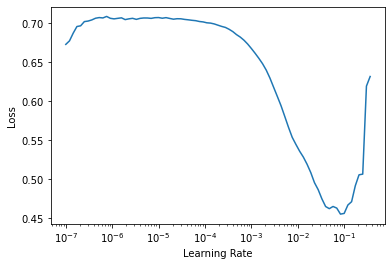

In [104]:
learn = tabular_learner(dls, layers=[100], metrics=error_rate)
learn.lr_find()

In [105]:
learn.fit_one_cycle(20, lr_max=4e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.565097,0.658819,0.435028,00:00
1,0.330023,0.531649,0.299435,00:00
2,0.234603,0.454718,0.163842,00:00
3,0.187338,0.658201,0.175141,00:00
4,0.200925,1.130496,0.209040,00:00
5,0.224614,1.479146,0.192090,00:00
6,0.203102,0.643415,0.192090,00:00
7,0.191385,1.427402,0.265537,00:00
8,0.172449,1.016799,0.231638,00:00
9,0.147688,0.938088,0.180791,00:00


### Stacking Classifier

In [106]:
clfs = [LGBMClassifier(subsample_freq=1, random_state = SEED), ExtraTreesClassifier(random_state= SEED), RandomForestClassifier(random_state = SEED)]

labels = [str(x) for x in clfs]

labels = [x[:x.index("(")] for x in labels]

In [107]:
for clf, label in zip(clfs, labels):

    scores = cross_val_score(clf, xs, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

Accuracy: 0.83 (+/- 0.01) [LGBMClassifier]
Accuracy: 0.82 (+/- 0.02) [ExtraTreesClassifier]
Accuracy: 0.83 (+/- 0.03) [RandomForestClassifier]


#### Tuning

In [35]:
def search_hyperparams(params):

    learning_rate = params[0]
    num_leaves = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators_lgbm = params[5]
    
    model = LGBMClassifier( 
                         subsample_freq=1, 
                         learning_rate=learning_rate,
                        num_leaves=num_leaves,
                        min_child_samples= min_child_samples,
                        subsample= subsample,
                        colsample_bytree = colsample_bytree,
                        n_estimators = n_estimators_lgbm)
    
    scores = cross_val_score(model, to.xs, to.y, cv=5, scoring='accuracy')
    
    return -scores.mean()

space = [
(1e-3, 1e-1, 'log-uniform'), #learning rate LGBM
(2, 128), #num_leaves LGBM
(1, 100), #min_child_samples LGBM
(0.05, 1.0), #subsample LGBM
(0.1, 1.0), #colsample_bytree LGBM
(100, 1000)] #n_estimators LGBM




#result = gp_minimize(search_hyperparams, space, verbose=1,n_calls = 30)

In [36]:
#result.x

In [37]:
def search_hyperparams(params):

    n_estimators = params[0]
    
    model = RandomForestClassifier(n_estimators = n_estimators)
    
    scores = cross_val_score(model, to.xs, to.y, cv=5, scoring='accuracy')
    
    return -scores.mean()

space = [(100, 1000)] #n_estimators LGBM




#result = gp_minimize(search_hyperparams, space, verbose=1,n_calls = 30)
#n_estimators = result.x[0]

In [65]:
def search_hyperparams(params):

    n_estimators = params[0]
    
    model = ExtraTreesClassifier(n_estimators = n_estimators)
    
    scores = cross_val_score(model, to.xs, to.y, cv=5, scoring='accuracy')
    
    return -scores.mean()

space = [(100, 1000)] #n_estimators LGBM




#result = gp_minimize(search_hyperparams, space, verbose=1,n_calls = 30)
#n_estimators = result.x[0]

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 5.6198
Function value obtained: -0.8077
Current minimum: -0.8077
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.6522
Function value obtained: -0.8043
Current minimum: -0.8077
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 3.6910
Function value obtained: -0.8054
Current minimum: -0.8077
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.8064
Function value obtained: -0.8065
Current minimum: -0.8077
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.6777
Function value obtained: -0.8032
Current minimum: -0.8077
Iteration No: 6 started. 

In [66]:
n_estimators

389

#### Validating

In [110]:
lgbm = LGBMClassifier(
                         subsample_freq=1, 
                         learning_rate=0.022941144328643994,
                        num_leaves=59,
                        min_child_samples= 2,
                        subsample= 0.9450916679006104,
                        colsample_bytree = 0.6069593960609855,
                        n_estimators = 447,
                        random_state = SEED)
lgbm.fit(xs, y)
lgbm.score(valid_xs, valid_y)

0.8192090395480226

In [108]:
rf = RandomForestClassifier(n_estimators = 140, random_state = SEED)
rf.fit(xs, y)
rf.score(valid_xs, valid_y)

0.807909604519774

In [109]:
extra = ExtraTreesClassifier(n_estimators = 389, random_state = SEED)
extra.fit(xs, y)
extra.score(valid_xs, valid_y)

0.8135593220338984

### Confusion Matrix

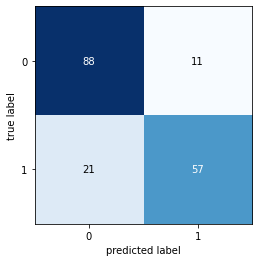

In [111]:
cm = confusion_matrix(valid_y, lgbm.predict(valid_xs))

fig, ax = plot_confusion_matrix(conf_mat=cm)

plt.show()


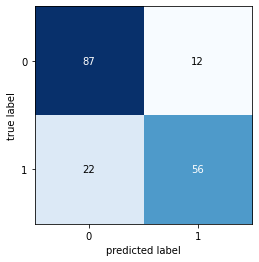

In [112]:
cm = confusion_matrix(valid_y, rf.predict(valid_xs))

fig, ax = plot_confusion_matrix(conf_mat=cm)

plt.show()


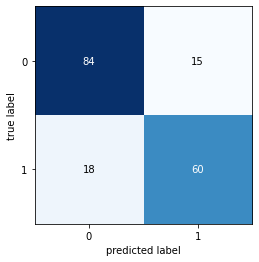

In [113]:
cm = confusion_matrix(valid_y, extra.predict(valid_xs))

fig, ax = plot_confusion_matrix(conf_mat=cm)

plt.show()


### Definitive Model of Random Forest

In [115]:
features = to.xs
label = to.y

In [116]:
lgbm.fit(features, label)
rf.fit(features, label)
extra.fit(features, label)

ExtraTreesClassifier(n_estimators=389, random_state=42)

##### Making Predictions

In [117]:
to_test = TabularPandas(test, procs=procs, cat_names=cat, cont_names=cont)

In [126]:
lgbm_res = lgbm.predict(to_test.xs)
rf_res = rf.predict(to_test.xs)
extra_res = extra.predict(to_test.xs)

In [119]:
dl = learn.dls.test_dl(test)
preds = learn.get_preds(dl=dl)[0].numpy()
learner_result = np.array([x.argmax() for x in preds])

In [120]:
res = (rf_res + learner_result) / 2
res = [vote(x) for x in res]

In [121]:
accuracy_score(y_test, learner_result)

0.8038277511961722

In [122]:
accuracy_score(y_test, lgbm_res)

0.7703349282296651

In [123]:
accuracy_score(y_test, rf_res)

0.7799043062200957

In [127]:
accuracy_score(y_test, extra_res)

0.7655502392344498

In [124]:
accuracy_score(y_test, res)

0.7679425837320574

#### Creating results.csv

In [52]:
sub = pd.Series(learner_result, index=ID, name='Survived')
sub.to_csv("results.csv", header=True)